In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import backend as K
import keras.utils
from tensorflow.keras import regularizers

2025-01-09 19:15:18.800668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
PATH_SOURCE = "/home/jbassham/jack/data/weddell/1992_2020"
PATH_DEST = PATH_SOURCE

In [4]:
###CODE ADAPTED FROM Lauren Hoffman###

In [5]:
def norm(data):
    
    data_mean = np.nanmean(data)
    data_std = np.nanstd(data)
    data_norm = (data - data_mean)/data_std

    return data_norm

In [6]:
def nto0(data):
    # Convert nan values in data to 0
    data[np.isnan(data)] = 0
    return data

In [7]:
# Loss Function ###(Hoffman)### 
#define NRMSE function
def norm_root_mean_squared_error(y_true,y_pred):
    return  (K.sqrt(K.mean(K.square(y_pred - y_true))))/(K.std(y_true))

In [ ]:
# Loss Function ###(Hoffman)### 
#define NRMSE function
def weighted_norm_root_mean_squared_error(y_true,y_pred, uncertainty):
    
    # Prevent divide by zero, replace zero uncertainty with small epsilon (ChatGPT)
    uncertainty = K.maximum(uncertainty, K.epsilon()) 
    
    return  (K.sqrt(K.mean(K.square(y_pred - y_true / uncertainty))))/(K.std(y_true)) # Weighted NRMSE

### Notes Lost Function
If NRMSE 
* Normalize by uncertainty (K.std(y_true) --> ((y_error))
* Use high uncertainty for land (where nan --> 0)

Add complexity of the model to loss function? 
* Can build loss function + number of neurons used

In [8]:
# New Loss Function
def loss(y_true,y_pred,error):
    return  (K.sqrt(K.mean(K.square(y_pred - y_true))))/(error)

In [9]:
#define pearson correlation
###(Hoffman)###
def tf_pearson(y_true, y_pred):
    return (K.sum((y_true-K.mean(y_true))*(y_pred-K.mean(y_pred))))/((K.sqrt(K.sum(K.square(y_true-K.mean(y_true)))))*(K.sqrt(K.sum(K.square(y_pred-K.mean(y_pred))))))

In [10]:
def calc_corr(pre, tru):
    """Calculates Pearson Correlation given true 'tru' and predicted 'pre' values"""
    
    M_tru = np.nanmean(tru, axis = 0)
    M_pre = np.nanmean(pre, axis = 0)
    
    # Perason Correlation
    corr1 = np.nansum((tru - M_tru) * (pre - M_pre), axis = 0)
    corr2 = np.sqrt(np.nansum((tru - M_tru)**2, axis = 0)) * np.sqrt(np.nansum((pre - M_pre)**2, axis = 0))
    
    corr = corr1/corr2

    return corr

In [ ]:
def new_calc_skill(pre, tru):
    """
    Calculates model skill represending the model error compared to the standard deviation of data
    
    Second term numerator is the Mean Squared Error
    
    Second term denominator is the variance in the true values
    
    """    
    
    skill1 = np.nanmean((tru - pre)**2, axis = 0) # MSE
    skill2 = np.nanmean((tru - np.nanmean(tru, axis = 0))**2, axis = 0) # Variance in true values
    
    if np.isnan(skill1).any() or np.isnan(skill2).any() or (skill2 == 0).any:
        print("Nan in skill")
    
    skill = 1 - skill1/skill2
    
    return skill

In [11]:
def calc_skill(pre, tru):
    """
    Lauren et al.
    
    Calculates model skill given true given 'true' predicted 'pred' values
    
    
    """  
    
    # Skill u component
    skill1 = np.sqrt(np.nanmean((tru - pre)**2, axis = 0))
    skill2 = np.sqrt(np.nanmean((tru - np.nanmean(tru, axis = 0))**2, axis = 0))
    
    skill = 1 - skill1/skill2
    
    return skill

## TRY NEW SKILL - Weighted Skill##
    # Weighting points with large uncertainties less
# 1 - var( (m-itry)/uncertainty )/var(itry/uncertainty)

In [12]:
fnam = "motion_ppv4_latlon_sh_1992_2020.npz"

data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
ui = data['u'] # zonal ice velocity
vi = data['v'] # meridional ice velocity
error = data['error']
lat = data['lat']
lon = data['lon']
time = data['time']

In [13]:

fnam = "con_nimbus7_latlon_sh_1992_2020.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
ic = data['ic'] # zonal ice velocity

In [14]:

fnam = "wind_JRA55_latlon_global_1992_2020.npz"
data = np.load(os.path.join(PATH_SOURCE, fnam), allow_pickle=True)
uw = data['u']
vw = data['v']

In [15]:

# Mask ice concentration

ic_raw = np.round(ic * 250)

# Mask 
# 251 pole hole
# 252 unused data
# 253 coastline
# 254 
ic = np.where((ic_raw == 251) | (ic_raw == 252) | (ic_raw == 253) | (ic_raw == 254), np.nan, ic)

# Filter points with ice error greater than 999 and 0 concentration ice motion
# Create mask
mask = (ic == 0) | (np.isnan(ic)) | (error >= 999) | (error <= -999)

# Mask points
ui = np.where(mask, np.nan, ui) 
uv = np.where(mask, np.nan, vi)

In [16]:
# # Blow error at ui and vi nan points to 9999
# error_9999 = np.where((np.isnan(ui)) | np.isnan(vi)), 9999, error)

In [17]:

# Shift present day parameters forward one day
ui_today = ui[1:,:,:]
vi_today = vi[1:,:,:]
uw_today = uw[1:,:,:]
vw_today = vw[1:,:,:]
time_today = time[1:]
uc_today = error[1:,:,:]
# error_today = error_9999[1:,:,:]

# Remove last day from previous day parameters
ui_yest = ui[:-1:,:,:]
vi_yest = vi[:-1:,:,:]
ic_yest = ic[:-1,:,:]
time_yest = time[:-1]
uc_yest = error[:-1,:,:]
# error_yest = error_9999[:-1,:,:]

print("Days shifted")

Days shifted


In [18]:

# Normalize components

ui_today = norm(ui_today)
vi_today = norm(vi_today)
uw_today = norm(uw_today)
vw_today = norm(vw_today)

ui_yest = norm(ui_yest)
vi_yest = norm(vi_yest)
ic_yest = norm(ic_yest)

uc_today = norm(uc_today)
uc_yest = norm(uc_yest)

In [19]:
# Convert all NaN gridpoints to 0 (cnn won't handle NaN values)

ui_today = nto0(ui_today)
vi_today = nto0(vi_today)
uw_today = nto0(uw_today)
vw_today = nto0(vw_today)

ui_yest = nto0(ui_yest)
vi_yest = nto0(vi_yest)
ic_yest = nto0(ic_yest)

uc_today = nto0(uc_today)
uc_yest = nto0(uc_yest)

In [20]:
# TODO Blow up uncertainty at 

In [21]:

# Initialize training arrays

m_time = len(time) - 1 # number of time steps (-1 for day shift)
# NOTE in cnn, nt is number of training examples/ datapoints
# NOTE because they're images shaped (nlat, nlon) for each time step
n_lat = len(lat)
n_lon = len(lon)
n_in = 3 # number input "channels" (variables; u and v wind, and concentration)

x = np.zeros((m_time, n_lat, n_lon, n_in)) # input array shaped (time, lat, lon, number inputs)

n_out = 2 # number target variables (variables; u and v ice velocity)

y = np.zeros((m_time, n_lat, n_lon, n_out)) # training output array shaped (time, lat, lon, number outputs)

# Fill input and output arrays with inputs
# NOTE - if I'm training and testing the fit with the same u and v velocity components from 2020, do we actually see performance?
# NOTE - do we need to distinguish between input and output dimensions - ie (m, n_yH0 * n_yW0 * n_Cy) vs (m,n_H0,n_W0,n_C0)

x[:,:,:,0] = uw_today
x[:,:,:,1] = vw_today
x[:,:,:,2] = ic_yest

y[:,:,:,0] = ui_today
y[:,:,:,1] = vi_today

In [35]:
# TRY WITHOUT SHUFFLING
# Take out seasonal cycle

# 80% train and 20% test split of time steps

i_split = int(0.8 * m_time) # split point at 80% time steps

x_train = x[:i_split,:,:,:]
y_train = y[:i_split,:,:,:]

m_train = x_train.shape[0]

x_test = x[i_split:,:,:,:]
y_test = y[i_split:,:,:,:]

m_test = x_test.shape[0]


print(np.shape(y_train))
print(np.shape(y_test))
# print(i_train)
print(n_lat)
print(n_lon)
print(n_in)
print(n_out)

print("")
print("train dates: ")
print(f"{time[0]} to", end = " ")
print(time[(i_split-1)])


print("")
print("test dates: ")
print(f"{time[i_split]} to", end = " ")
print(time[-1])

(8473, 81, 522, 2)
(2119, 81, 522, 2)
81
522
3
2

train dates: 
1992-01-01T00:00:00.000000 to 2015-03-13T00:00:00.000000

test dates: 
2015-03-14T00:00:00.000000 to 2020-12-31T00:00:00.000000


In [20]:

# # Generate 80% train and 20% test split of time steps

# # CANT COMPARE TO ERROR OR PARAMETERS WITH RANDOMIZATION BEFORE TEST SPLIT

# # Shuffle time indices (to avoid seasonal bias)
# indices = np.arange(m_time)
# # Initialize random number generator
# np.random.seed(13) # 13 is arbitrary - but keeping it constant maintains constant output
# np.random.shuffle(indices)

# ### HAD A MISTAKE WITH 20 TRAIN and 80 TEST SPLIT --- TRY THE OTHER WAY

# i_split = int(0.8 * m_time) # split point at 80% time steps

# i_train = indices[:i_split] # first 80% for train
# m_train = len(i_train)
# i_test = indices[i_split:] # last 20% for test
# m_test = len(i_test)

# x_train = x[i_train,:,:,:]
# y_train = y[i_train,:,:,:]

# x_test = x[i_test,:,:,:]
# y_test = y[i_test,:,:,:]

# print(np.shape(y_train))
# print(m_train)
# print(n_lat)
# print(n_lon)
# print(n_in)
# print(n_out)

(8473, 81, 522, 2)
8473
81
522
3
2


In [36]:
# Flatten y train to m,n matrix shaped (training examples, flattened image)
# NOTE cnn output is this matrix - and so we reshape to get our images/ parameters backs
y_train = np.reshape(y_train, (m_train, n_lat * n_lon * n_out))

In [37]:
###(Hoffman)###
#filters: sizes & nos.
# sizes are chosen based on the conventional Visual Geometry Group Network (VGGNet) architecture
# maintain consistency with the architecture of Zhai and Bitz (2021)
# NOTE - might need to change based on input map size
f2=2
f3=3
nf1=7
nf2=14
nf3=28
nf4=56
nf5=112
l2r = 0.01 # lambda, ridge parameter

In [38]:
###(Hoffman)### (changed naming convention)
# Build Model 


# Five repetitions of the block unit
    # 2D convolution, rectified linear unit (ReLU), 2D max pooling
# % 20 dropout layer
# Flattening to a 1D vector (for each time step? resulting in m, n matrix?)
# Regresion onto a 1D layer (Dense layer) - giving output predictions
# Output reshaped to maps of u and v sea ice velocity predictions

#Convolutional and ReLU layers are carried out with (1, 1) strides and (3, 3) filter sizes,
#whereas the max pooling strides and filter sizes are (2, 2)

# For each of the respective repeating block units, there are 7, 14, 28, 56, and 112 filters.

# Optimization is carried out with an Adam optimizer and a normalized root-mean-square error as the loss function

# ridge regression with a ridge parameter lambda = 10 ^ -2

cnn_model = keras.models.Sequential([
    #layer 1
    keras.layers.Conv2D(nf1,(f3,f3),strides=(1,1),padding='same',activation='relu',input_shape=(n_lat,n_lon,n_in),kernel_regularizer=regularizers.l2(l2r)),
    keras.layers.MaxPooling2D((f2,f2),strides=(2,2),padding='valid'),
    #layer 2
    keras.layers.Conv2D(nf2,(f3,f3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(l2r)),
    keras.layers.MaxPooling2D((f2,f2),strides=(2,2),padding='valid'),
    #layer 3
    keras.layers.Conv2D(nf3,(f3,f3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(l2r)),
    keras.layers.MaxPooling2D((f2,f2),strides=(2,2),padding='valid'),
    #layer 4
    keras.layers.Conv2D(nf4,(f3,f3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(l2r)),
    keras.layers.MaxPooling2D((f2,f2),strides=(2,2),padding='valid'),
    #layer 5
    keras.layers.Conv2D(nf5,(f3,f3),strides=(1,1),padding='same',activation='relu',kernel_regularizer=regularizers.l2(l2r)),
    keras.layers.MaxPooling2D((f2,f2),strides=(2,2),padding='valid'),
    #dropout, flatten & fully connected
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense((n_lat*n_lon*n_out)),
    ])

print("Model Built")

2025-01-09 19:59:52.013812: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model Built


In [39]:
# Log history

from datetime import datetime
dt = datetime.now().strftime('%y%m%d_%H%M')
print(dt)

fnam_log = f'cnn_weighted_history_1992_2020_{dt}.txt'
log_file = os.path.join(PATH_DEST, fnam_log)


class HistoryLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_file):
        super(HistoryLogger, self).__init__()
        self.log_file = log_file

    def on_epoch_end(self, epoch, logs=None):
        with open(self.log_file, 'a') as f:
            f.write(f'Epoch {epoch + 1}: ')
            for key, value in logs.items():
                f.write(f'{key}={value:.4f}, ')
            f.write('\n')

250109_2000


In [ ]:
###(Hoffman)### (changed batch size from 365 days to 30 - due to only one year data)
# Removed validation 'validation_data=(X_val,Y_val)'
#compile and train model
cnn_model.compile(optimizer='adam',loss=weighted_norm_root_mean_squared_error,metrics=['accuracy',tf_pearson])
print(cnn_model.summary())

history = cnn_model.fit(
    x_train,y_train,
    epochs=50,
    batch_size=30,
    shuffle=True,
    # validation_data = (x_val, y_val),
    callbacks = HistoryLogger(log_file)
)
print(history)

print('Train Complete')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 81, 522, 7)        196       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 261, 7)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 261, 14)       896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 130, 14)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 130, 28)       3556      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 65, 28)       0

In [41]:
###(Hoffman)###
#test model prediction
y_true_te = y_test
y_pred_te = cnn_model.predict(x_test)

print('Test Complete')

67/67 [==============================] - 4s 60ms/step
Test Complete


(2119, 81, 522, 2)
(2119, 84564)
(2119, 81, 522, 2)


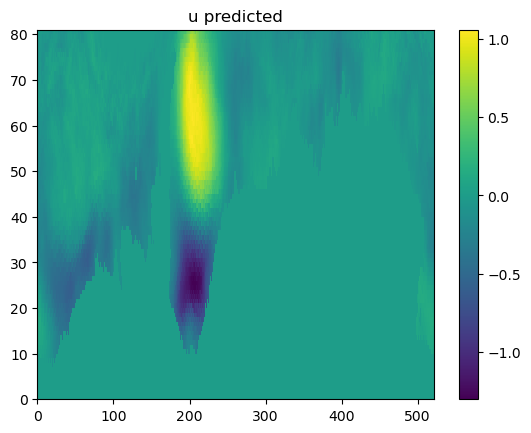

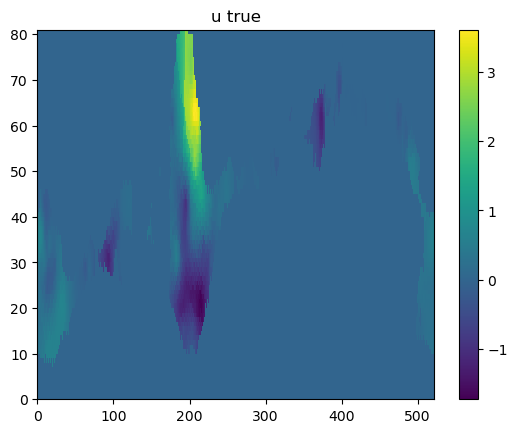

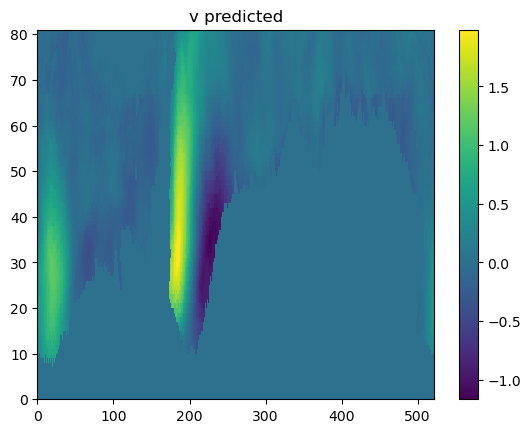

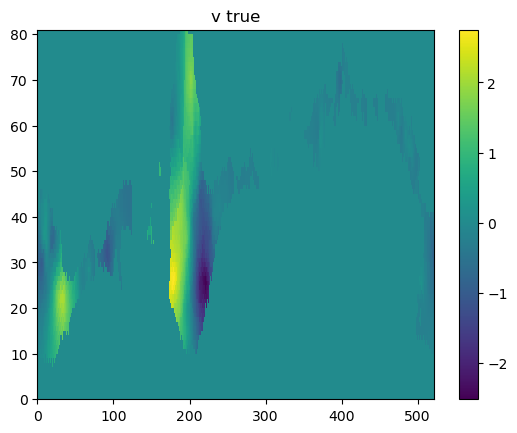

In [42]:
print(np.shape(y_true_te))
print(np.shape(y_pred_te))

y_pred_te_out = np.reshape(y_pred_te, (m_test, n_lat, n_lon, n_out))
print(np.shape(y_pred_te_out))


plt.pcolormesh(y_pred_te_out[0,:,:,0])
plt.title("u predicted")
plt.colorbar()
plt.show()

plt.pcolormesh(y_true_te[0,:,:,0])
plt.title("u true")
plt.colorbar()
plt.show()

plt.pcolormesh(y_pred_te_out[0,:,:,1])
plt.title("v predicted")
plt.colorbar()
plt.show()

plt.pcolormesh(y_true_te[0,:,:,1])
plt.title("v true")
plt.colorbar()
plt.show()

In [57]:
# from datetime import datetime
# dt = datetime.now().strftime('%y%m%d_%H%M')
# print(dt)

241031_1006


In [55]:
def plots(data_values, lon, lat, 
            main_title = None, titles = None, y_labels = None, x_labels = None, c_labels = None, 
            vmin = None, vmax = None, cmap = 'viridis',
            save_path = None):
    """

    Input Parameters:
    - data: list of data shaped [time, y, x]
    - y_values, x_values: lists of coordinate variables, ie: lat, lon
    - sup_title: main title for plot
    - titles, y_labels, x_labels: as lists for each subplot
    - c_labels: list of colorbar labels
    - vmin, vmax: min and max colorbar values
    - interval: time delay between frames, ms
    - save_path
    
    """     
    
    # Number of plots based on number of c data inputs
    nplots = len(data_values)

    # Create subplot grid based on number of plots
    fig, axs = plt.subplots(int(nplots/2), int(nplots/2), figsize = (6 * nplots, 6* nplots))

    # Handle case for one plot
    if nplots == 1:
        # axs not a list
        axs = [axs]

    # Create default case for titles and lables
    if titles is None:
        titles = [f"Data[{i+1}]" for i in range(nplots)]
    
    if x_labels is None:
        x_labels = ["lon"] * nplots

    if y_labels is None:
        y_labels = ["lat"] * nplots
    
    if c_labels is None:
        c_labels = ["Value"] * nplots

    plot_objs = [] # List to hold plot objects

    # Plot subplots
    for i, data in enumerate(data_values):
        plot_obj = axs[i].pcolormesh(data, lon, lat, cmap=cmap)
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(x_labels[i])
        axs[i].set_ylabel(y_labels[i])
        fig.colorbar(plot_obj, ax = axs[i], label = c_labels[i])
        if main_title is not None:
            fig.suptitle(main_title)
        plot_objs.append(plot_obj)
        
    # Save figure
    if save_path is not None:      
        plt.savefig(save_path, format='jpeg', dpi=300)
            
    plt.show()
    
    return

In [47]:
ilon_weddell = np.where((lon>= -70) & (lon<= 0))[0]
ilat_weddell = np.where((lat>= -80) & (lat<= -62))[0]

In [44]:
u_true = y_true_te[:,:,:,0]
v_true = y_true_te[:,:,:,1]

u_pred = y_pred_te_out[:,:,:,0]
v_pred = y_pred_te_out[:,:,:,1]

corr_u = calc_corr(u_pred, u_true)
corr_v = calc_corr(v_pred, v_true)

skill_u = calc_skill(u_pred, u_true)
skill_v = calc_skill(v_pred, v_true)

/tmp/ipykernel_3717871/574377205.py:11: RuntimeWarning: invalid value encountered in divide
  corr = corr1/corr2
/tmp/ipykernel_3717871/3683812884.py:8: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - skill1/skill2


### Save predicted and true values

In [45]:
# Save predicted and true values

fnam = f"predictions_cnn_{dt}_1992_2020.npz"

np.savez_compressed(os.path.join(PATH_DEST, fnam), u_true = u_true, v_true = v_true, u_pred = u_pred, v_pred = v_pred)
print(f"Variables saved at path {PATH_DEST}/{fnam}")

Variables saved at path /home/jbassham/jack/data/weddell/1992_2020/predictions_cnn_250109_2000_1992_2020.npz


In [55]:
# Save stats in .npz variable

fnam = f"stats_cnn_{dt}_1992_2020_.npz"

np.savez_compressed(os.path.join(PATH_DEST, fnam), corr_u = corr_u, corr_v = corr_v, skill_u = skill_u, skill_v = skill_v, lat = lat, lon = lon)
print(f"Variables saved at path {PATH_DEST}/{fnam}")

Variables saved at path /home/jbassham/jack/data/weddell/1992_2020/stats_cnn_1992_2020.npz


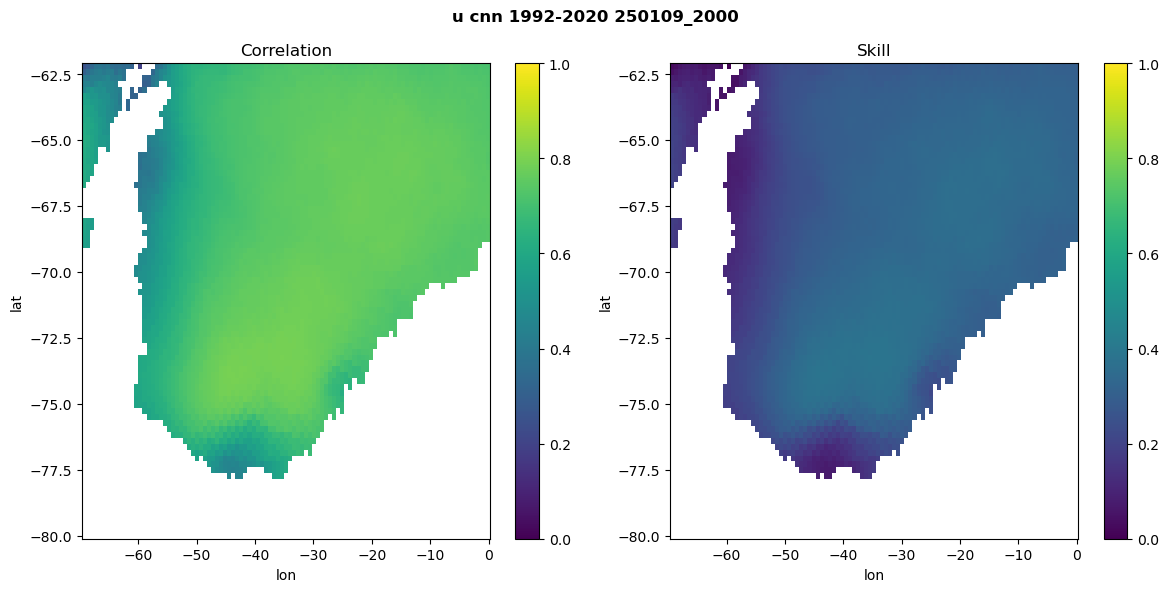

In [48]:
# Plot statistics u
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
plt0 = axs[0].pcolormesh(lon[ilon_weddell], lat[ilat_weddell], corr_u[np.ix_(ilat_weddell, ilon_weddell)], vmin = 0, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('Correlation')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon[ilon_weddell], lat[ilat_weddell], skill_u[np.ix_(ilat_weddell, ilon_weddell)], vmin = 0, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('Skill')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')


fig.suptitle(f'u cnn 1992-2020 {dt}', fontweight = 'bold')
fig.tight_layout()

fnam = f"u_cnn_1992_2020_{dt}_01.jpeg"
save_path = os.path.join(PATH_DEST, fnam)
plt.savefig(save_path, format='jpeg', dpi=300)

plt.show()

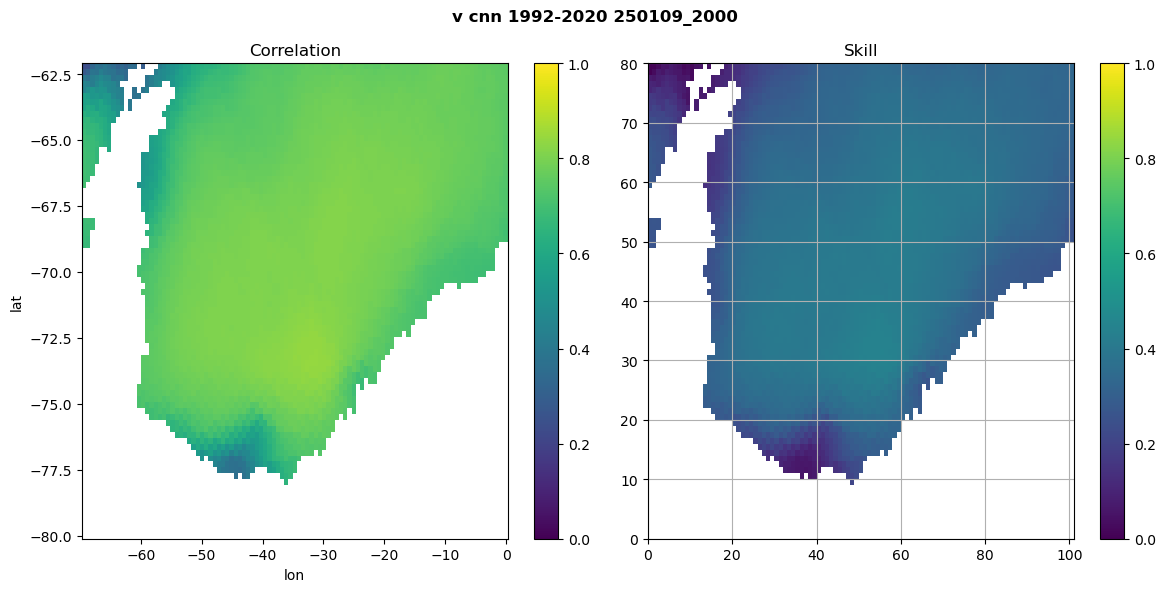

In [49]:
# Plot statistics v
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))
plt0 = axs[0].pcolormesh(lon[ilon_weddell], lat[ilat_weddell], corr_v[np.ix_(ilat_weddell, ilon_weddell)], vmin = 0, vmax = 1)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('Correlation')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(skill_v[np.ix_(ilat_weddell, ilon_weddell)], vmin = 0, vmax = 1)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('Skill')
# axs[1].set_xlabel('lon')
# axs[1].set_ylabel('lat')
axs[1].grid('true')


fig.suptitle(f'v cnn 1992-2020 {dt}', fontweight = 'bold')
fig.tight_layout()

# fnam = f"v_cnn_1992_2020_{dt}_01.jpeg"
# save_path = os.path.join(PATH_DEST, fnam)
# plt.savefig(save_path, format='jpeg', dpi=300)

plt.show()

Min Correlation: -0.11840141001880805
Min Skill: -inf

Max Correlation: 0.8209325867811463
Max Skill: 0.4076023397394304


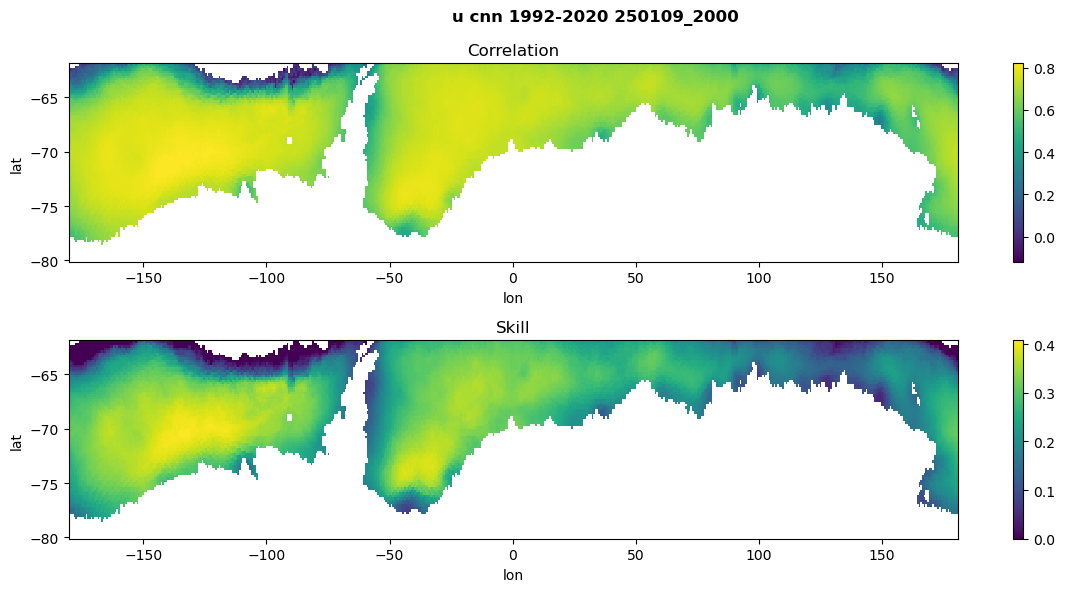

In [50]:
min_corr_u = np.nanmin(corr_u)
min_skill_u = np.nanmin(skill_u)

print(f"Min Correlation: {min_corr_u}")
print(f"Min Skill: {min_skill_u}")
print("")

max_corr_u = np.nanmax(corr_u)
max_skill_u = np.nanmax(skill_u)

print(f"Max Correlation: {max_corr_u}")
print(f"Max Skill: {max_skill_u}")

# Plot statistics u (southern ocean)
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12,6))
plt0 = axs[0].pcolormesh(lon, lat, corr_u)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('Correlation')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, skill_u, vmin = 0, vmax = max_skill_u)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('Skill')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')


fig.suptitle(f'u cnn 1992-2020 {dt}', fontweight = 'bold')
fig.tight_layout()

fnam = f"u_cnn_1992_2020_{dt}_wholeso.jpeg"
save_path = os.path.join(PATH_DEST, fnam)
plt.savefig(save_path, format='jpeg', dpi=300)

plt.show()

Min Correlation: -0.1197064237795287
Min Skill: -inf

Max Correlation: 0.8420488348551219
Max Skill: 0.44586507313477686


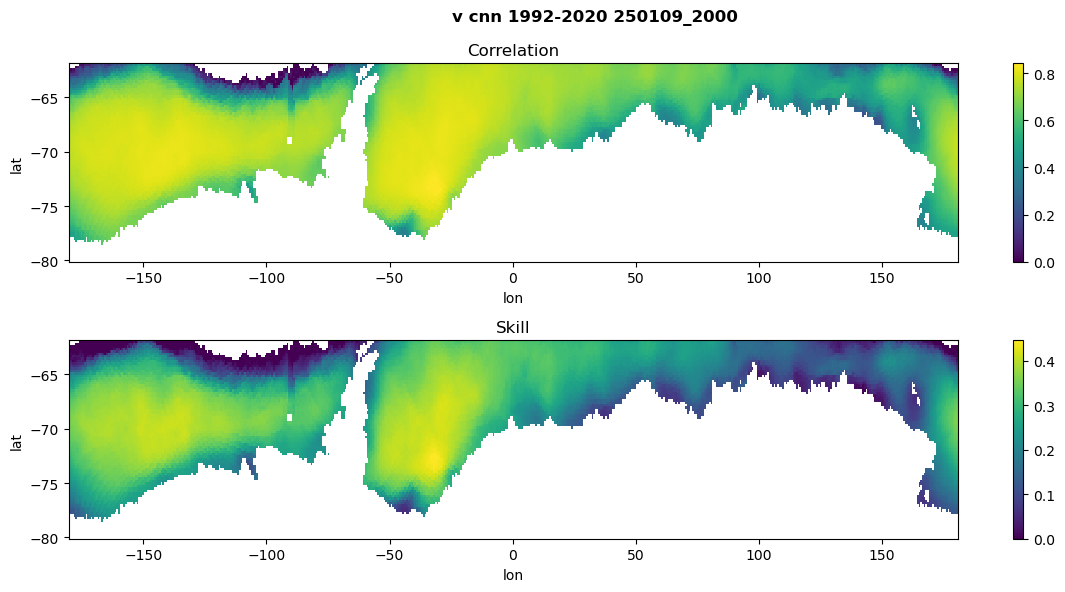

In [51]:
min_corr_v = np.nanmin(corr_v)
min_skill_v = np.nanmin(skill_v)

print(f"Min Correlation: {min_corr_v}")
print(f"Min Skill: {min_skill_v}")
print("")

max_corr_v = np.nanmax(corr_v)
max_skill_v = np.nanmax(skill_v)

print(f"Max Correlation: {max_corr_v}")
print(f"Max Skill: {max_skill_v}")

# Plot statistics u (southern ocean)
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (12,6))
plt0 = axs[0].pcolormesh(lon, lat, corr_v, vmin = 0, vmax = max_corr_v)
fig.colorbar(plt0, ax = axs[0])
axs[0].set_title('Correlation')
axs[0].set_xlabel('lon')
axs[0].set_ylabel('lat')

plt1 = axs[1].pcolormesh(lon, lat, skill_v, vmin = 0, vmax = max_skill_v)
fig.colorbar(plt1, ax = axs[1])
axs[1].set_title('Skill')
axs[1].set_xlabel('lon')
axs[1].set_ylabel('lat')


fig.suptitle(f'v cnn 1992-2020 {dt}', fontweight = 'bold')
fig.tight_layout()

fnam = f"v_cnn_1992_2020_{dt}_wholeso.jpeg"
save_path = os.path.join(PATH_DEST, fnam)
plt.savefig(save_path, format='jpeg', dpi=300)

plt.show()

 ### NOTES
 * Can cnn models handle dynamic input (varying grid size and resolution, varying grid types, inputs)?
 * if I'm training and testing the fit with the same u and v velocity components from 2020, do we actually see performance?
   * NOTE - without the train and test split we don't know how the model will produce predictions with 'unseen' data
* Future - ensemble runs (forecasting/ nowcasting)
* "The train, validate, and test years are shuffled
10 times to produce data for 10 different ensemble runs for
each ML model"
* "88%–6%–6% split"

In [ ]:
# TODO - speed and direction correlation and skill?